# Plotting trajectory of the Dawn spacecraft 

## First load packages

In [1]:
%matplotlib widget

import sys
sys.path.append('src/')

import os
import spiceypy as spice # SPICE is the JPL software for working with all sorts of geometry problems related to spacecraft observations 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

This notebook uses SPICE. NASA's Navigation and Ancillary Information Facility (NAIF) offers NASA flight projects and NASA funded researchers the "SPICE" (Spacecraft, Planet, Instrument, C-matrix, Events) observation geometry information system to assist scientists in planning and interpreting scientific observations from space-based instruments aboard robotic planetary spacecraft. Here is the SPICE website: https://naif.jpl.nasa.gov/naif/ 

SPICE is extemely well documented and has extensive tutorials. 
Tutorials are available here: https://naif.jpl.nasa.gov/naif/tutorials.html
Also, there are programming lessons available here: https://naif.jpl.nasa.gov/naif/lessons.html 

SPICE is available in many different languages but not in Python. However, SpicyPy is a collection of wrapper functions that run SPICE in C behind the scenes. So, in order to look for references for individual functions, it is better to look at the documentation for the C implementation: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/index.html

The goal of this class is not to learn SPICE but occasionally we might use it to get real spacecraft and planetary trajectories, rotational states as well as for solving various geometry problem. If you go to work for space missions, you will likely encounter SPICE, so it is a good thing to learn. 

## Load SPICE kernels via a metakernel, which is just a text file that contains a list of kernels

In [2]:
metakernel_path = '/Users/koichikimoto/Desktop/Space/AA179/SPICE/metakernel_dawn.txt'
spice.furnsh(metakernel_path)

SpiceNOSUCHFILE: 
================================================================================

Toolkit version: CSPICE_N0067

SPICE(NOSUCHFILE) --

The first file '/Users/eai/Documents/Teaching/AA179_Anton/SPICE/lsk/naif0010.tls' specified by KERNELS_TO_LOAD in the file /Users/koichikimoto/Desktop/Space/AA179/SPICE/metakernel_dawn.txt could not be located.

furnsh_c --> FURNSH --> ZZLDKER

================================================================================

## Load all kernels from the given folder. In this case, I put all the SPK kernels in this folder

In [7]:
spk_path = '/Users/eai/Documents/Teaching/AA179_Anton/SPICE/dawn_spk/'
spk_list = os.listdir(spk_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/eai/Documents/Teaching/AA179_Anton/SPICE/dawn_spk/'

In [ ]:
for spk_file in spk_list:
    spice.furnsh(spk_path + spk_file)

## Some useful definitions for degrees, radians, minutes of arc (or arcminutes), seconds of arc (arcseconds)

In [ ]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

AU      = 149597870700.0 # astronomical unit (m)
R_Ceres = 470000.0 (m)

## Let's set the dates when we want to know the trajectory of the Dawn spacecraft

In [ ]:
n_steps = 2000
# we are going to get positions between these two dates
t_start = '2007 OCT 08 20:17:22.0000'
t_end   = '2011 APR 08 17:17:22.0000'

## Convert those dates into so called ephemeris time and create an array of times

In [ ]:
# get et values one and two, we could vectorize str2et
et_start = spice.str2et(t_start)
et_end   = spice.str2et(t_end)
# get times
times = np.linspace(et_start, et_end, n_steps)

# allocate variables for planet, asteroid and spacecraft states (state is a word we use to describe position and velocity together)

In [ ]:
state_dawn  = np.zeros((6, len(times)))
state_earth  = np.zeros((6, len(times)))
state_mars  = np.zeros((6, len(times)))
state_vesta  = np.zeros((6, len(times)))

## ok, this is somewhat involved now, but this is how we get all the states from the SPICE kernels

-203 is the SPICE code for the Dawn spacecraft. Artificial objects have negative codes. You can find all the codes here: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html
3 is the Earth-Moon center of mass (or barycenter). 4 is the Mars-system barycenter, 2000004 is Vesta.
ECLIPJ2000 is the code for the reference frame. In this case, it is an eclitic-based reference frame
'none' refers to making no corrections. But what corrections there could be - these are the corrections for the light travel time. So 
for example we can want to get the positions "as seen", that is the apparent positions when the light from that object reached the observer
Finally 10 refers to origin of the reference frame, which is the Sun in this case.

In [ ]:
# Run spkez
for i in range(len(times)):
    state_dawn[:,i], _  = spice.spkez(-203, times[i], 'ECLIPJ2000', 'none', 10) #negative code for man-made object
    state_earth[:,i], _  = spice.spkez(3, times[i], 'ECLIPJ2000', 'none', 10)
    state_mars[:,i], _  = spice.spkez(4, times[i], 'ECLIPJ2000', 'none', 10)
    state_vesta[:,i], _  = spice.spkez(2000004, times[i], 'ECLIPJ2000', 'none', 10)

state_dawn   = state_dawn * 1e3 # convert to meters and meters/second here. By default SPICE returns in km.
state_earth  = state_earth * 1e3
state_mars   = state_mars * 1e3
state_vesta  = state_vesta * 1e3

## Let's plot some orbits

In [16]:
ax = plt.figure().add_subplot(projection='3d')
plt.plot(state_earth[0,:]/AU, state_earth[1,:]/AU, state_earth[2,:]/AU,'-b')
plt.plot(state_mars[0,:]/AU, state_mars[1,:]/AU, state_mars[2,:]/AU,'-r')
plt.plot(state_vesta[0,:]/AU, state_vesta[1,:]/AU, state_vesta[2,:]/AU,'-k')
plt.plot(state_dawn[0,:]/AU, state_dawn[1,:]/AU, state_dawn[2,:]/AU,'-m')

# setting title and labels 
ax.set_xlabel('x [AU]') 
ax.set_ylabel('y [AU]') 
ax.set_zlabel('z [AU]') 

NameError: name 'plt' is not defined

## This is not just a toy plot! This plot uses the best data humans have for the positions of the planets, asteroid vesta and the Dawn spacecraft as it flew from the Earth to Vesta.

## Let's now plot the orbits at Ceres
You can compare the plots below against this paper: 
https://www.sciencedirect.com/science/article/pii/S009457651931450X#:~:text=Using%20ion%20propulsion%2C%20Dawn%20operated,and%20rock%2C%20with%20diverse%20geology.

In [7]:
n_steps = 2000
# we are going to get positions between these two dates
t_start = '2015 FEB 08 20:17:22.0000'
t_end   = '2018 SEP 30 17:17:22.0000'

# get et values one and two, we could vectorize str2et
et_start = spice.str2et(t_start)
et_end   = spice.str2et(t_end)
# get times
times = np.linspace(et_start, et_end, n_steps)

state_dawn  = np.zeros((6, len(times)))
state_ceres  = np.zeros((6, len(times)))

# Run spkez
for i in range(len(times)):
    state_dawn[:,i], _  = spice.spkez(-203, times[i], 'J2000', 'none', 2000001)

state_dawn   = state_dawn * 1e3 # convert to meters and meters/second here. By default SPICE returns in km.
state_ceres  = state_ceres * 1e3

NameError: name 'spice' is not defined

Text(0.5, 0, 'z [$R_{Ceres}$]')

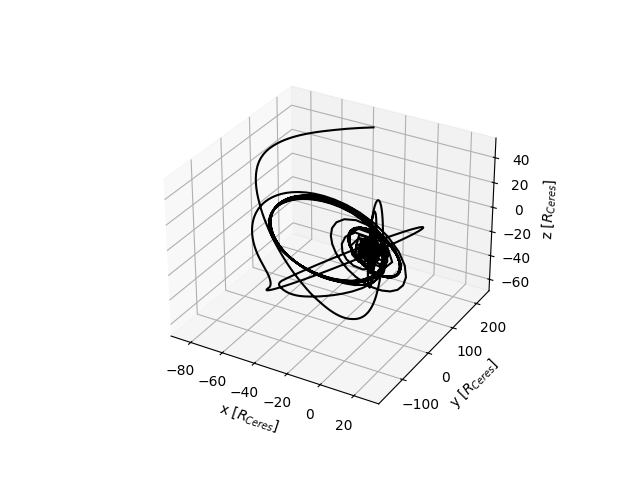

In [12]:
ax = plt.figure().add_subplot(projection='3d')
plt.plot(state_dawn[0,:]/R_Ceres, state_dawn[1,:]/R_Ceres, state_dawn[2,:]/R_Ceres,'-k')

# setting title and labels 
ax.set_xlabel(r'x [$R_{Ceres}]$') 
ax.set_ylabel(r'y [$R_{Ceres}$]') 
ax.set_zlabel(r'z [$R_{Ceres}$]') 

In [161]:
# spice.kclear() # finally we clear all the kernels 